# Compare tweets and party programs

https://github.com/adsieg/text_similarity/blob/master/Different%20Embeddings%20%2B%20Cosine%20Similarity%20%2B%20HeatMap%20illustration.ipynb 

https://www.machinelearningplus.com/nlp/cosine-similarity/


In [73]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime 
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
from gensim.models import Word2Vec
import re
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

In [125]:
programme = open('party_programmes/gruene.txt', "r").read()

In [74]:
#Cleaning text 

#also stole this from: https://github.com/adsieg/text_similarity/blob/master/Different%20Embeddings%20%2B%20Cosine%20Similarity%20%2B%20HeatMap%20illustration.ipynb
def preprocess(raw_text):

    # keep only words
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split 
    words = letters_only_text.lower().split()

    # remove stopwords
    stopword_set = set(stopwords.words("german"))
    cleaned_words = list(set([w for w in words if w not in stopword_set]))

    return cleaned_words

gruene_cleaned = preprocess(programme)

In [126]:
# get pre-trained model

# downloaded a German word embedding model from http://devmount.github.io/GermanWordEmbeddings/#download 
# das github von dem dude: https://github.com/devmount/GermanWordEmbeddings/blob/master/code/pca.ipynb


What I would need to do, to make this work:
- Get a better embedding model for German language [done]
- Loop each word into the model and calculate the mean (or weighted mean) [done]
- then calculate the cosine distance [done]
- this can work. currently the main thing is the German Language Model.

# Trying with the German FastText Wiki Model

In [106]:
import fasttext

In [133]:
#source https://fasttext.cc/docs/en/pretrained-vectors.html 
ft_model_wiki = fasttext.load_model("language_models/wiki.de.bin")

In [135]:
#source https://fasttext.cc/docs/en/crawl-vectors.html
ft_model_cc_wiki = fasttext.load_model("language_models/cc.de.300.bin")

In [136]:
# Simple test how a vector looks. it is pretty
ft_model_wiki['Gruene']
ft_model_cc_wiki['Gruene']

array([-6.66586831e-02, -1.20093264e-01,  2.17122920e-02, -4.39679995e-02,
        1.71260838e-03,  1.33931994e-01,  7.26640150e-02,  4.74838801e-02,
       -4.67565209e-02, -9.32673085e-03, -8.86969492e-02,  1.16495393e-01,
        1.84771400e-02, -2.54264902e-02, -7.09674060e-02, -3.34988385e-02,
        1.34711841e-03, -4.90736179e-02,  3.76501456e-02,  1.02975540e-01,
        2.81355320e-03,  6.00518845e-02, -3.26939635e-02, -7.31652826e-02,
        8.60609143e-05, -1.24841563e-01,  1.32975830e-02,  5.85928522e-02,
        6.27549365e-03,  2.52863467e-02, -6.64956495e-02,  1.12517796e-01,
        1.07481264e-01,  7.51210898e-02, -5.08116446e-02,  7.28011280e-02,
       -3.73899974e-02,  6.09375676e-03, -2.99078021e-02, -6.12091310e-02,
        3.24815474e-02, -2.56212112e-02,  1.73820311e-03, -1.72924343e-02,
       -3.84134129e-02,  1.07680857e-01,  3.57731767e-02, -5.43604977e-02,
       -3.34484950e-02, -2.56891251e-02,  3.07286717e-02, -7.17754066e-02,
        3.76838855e-02, -

In [188]:
# load in Annalena Baerbock tweets 
annalena = pd.read_csv("baerbock_tweets.csv")
annalena.head()


,Unnamed: 0,id,created_at,full_text,display_text_range,in_reply_to_user_id,in_reply_to_screen_name,is_quote_status,retweet_count,favorite_count,possibly_sensitive
0,0,1468233562742788111,Tue Dec 07 14:58:54 +0000 2021,"Mit dem #Koalitionsvertrag, den SPD, FDP und w...","[0, 226]",NaN,NaN,False,10,288,False
1,1,1466482642942054400,Thu Dec 02 19:01:22 +0000 2021,Mit der offiziellen Verabschiedung heute Abend...,"[0, 153]",2.179011e+09,ABaerbock,False,92,6208,NaN
2,2,1466482641578999817,Thu Dec 02 19:01:22 +0000 2021,Sich selbst zurücknehmen zu können und in den ...,"[0, 153]",2.179011e+09,ABaerbock,False,93,5288,NaN
3,3,1466482640102510601,Thu Dec 02 19:01:21 +0000 2021,Unser Land hat Angela Merkels politischer Ära ...,"[0, 212]",NaN,NaN,False,384,10470,NaN
4,4,1464983672415608834,Sun Nov 28 15:45:00 +0000 2021,Jüdische Gemeinden in aller Welt feiern ab heu...,"[0, 237]",NaN,NaN,False,183,3558,NaN


In [189]:
#mit einem fake sample tweet

cleaned_programm = gensim.utils.simple_preprocess(programme)
cleaned_tweet = gensim.utils.simple_preprocess("Karl Lauterbach hat ne geile Fliege und die ist rot")

program_vector = np.mean([ft_model[word] for word in cleaned_programm], axis = 0).reshape(1,-1)
tweet_vector = np.mean([ft_model[word] for word in cleaned_tweet], axis = 0).reshape(1,-1)

In [190]:
cosine_similarity(program_vector, tweet_vector)

array([[0.71076447]], dtype=float32)

In [191]:
# okay let's code a function to pump this through


def get_similarities(party_programme, tweet_df, lang_model, model_name = None):

    tweet_df = tweet_df.copy()

    #clean up the party program and the tweets
    cleaned_programm = gensim.utils.simple_preprocess(party_programme)
    cleaned_tweets = [gensim.utils.simple_preprocess(doc) for doc in tweet_df['full_text'].values]

    #calculate the document vector for the entire party programme (across the axis dimensions)
    program_vector = np.mean([lang_model[word] for word in cleaned_programm], axis = 0).reshape(1,-1)

    similarity_list = []
    #for each tweet
    for tweet in cleaned_tweets:

        #calculate the mean vector
        tweet_vector = np.mean([lang_model[word] for word in tweet], axis = 0).reshape(1,-1)

        #add to the final list
        similarity_list.append(cosine_similarity(program_vector,tweet_vector)[0][0])

    #add to the input df
    tweet_df['cleaned_tweets'] = cleaned_tweets
    tweet_df[f'w2v_cosine_similarity_{model_name}'] = similarity_list

    #return the df
    return tweet_df


In [213]:
#get a nice plot
def similarity_histo(result_df, model_ending, name = "Annalena Baerbock"): #erstmal mit Annalena als default. 

    col_name = f'w2v_cosine_similarity_{model_ending}'
    #get the mean cosine similarity 
    mean_cosine = np.mean(result_df[col_name])

    #plot a histogram of similarities
    plt.hist(result_df[col_name])
    plt.xlabel(f"Cosine Similarity (Using {model_ending})")
    plt.title(f"The mean similarity of {name}'s tweets \nwith their party program was {mean_cosine}")
    
    return plt.show()

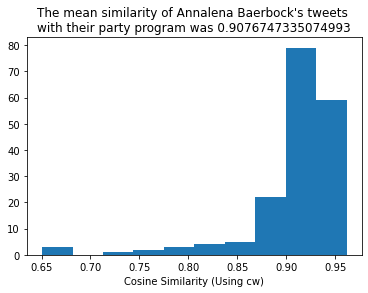

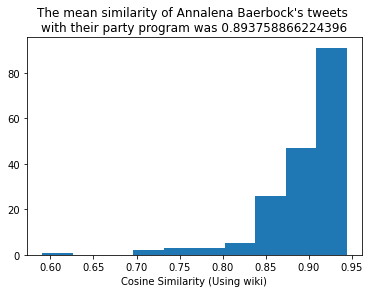

In [214]:
out_df_cw = get_similarities(programme, annalena, ft_model_cc_wiki, "cw")
similarity_histo(out_df_cw, "cw")

out_df_wiki = get_similarities(programme, annalena, ft_model_wiki, "wiki")
similarity_histo(out_df_wiki, "wiki")

(array([ 3.,  0.,  1.,  2.,  3.,  4.,  5., 22., 79., 59.]),
 array([0.65060306, 0.68171213, 0.7128212 , 0.74393027, 0.77503934,
        0.80614841, 0.83725748, 0.86836655, 0.89947562, 0.93058469,
        0.96169376]),
 <BarContainer object of 10 artists>)

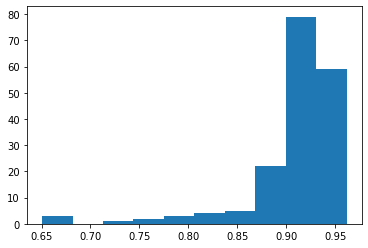

In [158]:
plt.hist(out_df.w2v_cosine_similarity)

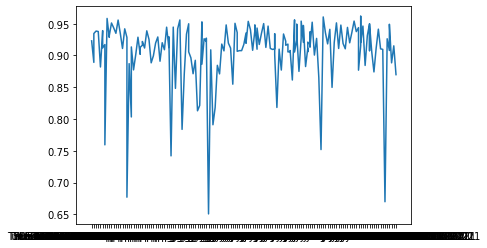

In [159]:
plt.plot(out_df['created_at'], out_df.w2v_cosine_similarity)